In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import sys
import numpy as np
sys.path.append("/global/cscratch1/sd/zuntz/TXPipe")
import txpipe

# Examining TXPipe + RAIL outputs

In [2]:
data_dir = "/global/cscratch1/sd/zuntz/TXPipe/data/cosmodc2-nz/outputs"

In [3]:
!ls -lh $data_dir

total 477G
-rw-r--r-- 1 zuntz zuntz  31M Oct  5 05:00 ideal_specz_catalog.pq
-rw-r--r-- 1 zuntz zuntz 1.2M Oct  5 05:02 lens_direct_calibration_model.pkl
-rw-r--r-- 1 zuntz zuntz  349 Oct  5 05:02 lens_photoz_model.pkl
-rw-r--r-- 1 zuntz zuntz 474G Oct  6 05:05 lens_photoz_pdfs.hdf5
-rw-r--r-- 1 zuntz zuntz 292K Oct 14 09:39 lens_photoz_realizations.hdf5
-rw-r--r-- 1 zuntz zuntz 251K Oct 14 09:39 lens_photoz_stack.hdf5
-rw-r----- 1 zuntz zuntz  45K Oct 14 08:57 lens_photoz_stack_dir.hdf5
-rw-r--r-- 1 zuntz zuntz 884K Oct 14 08:52 lens_somoclu_model.pkl
-rw-r--r-- 1 zuntz zuntz 1.6G Oct  7 05:55 lens_tomography_catalog.hdf5
drwxrwx--- 2 zuntz zuntz 4.0K Oct  7 05:53 old
-rw-r--r-- 1 zuntz zuntz  29K Oct  5 05:48 shear_photoz_stack.hdf5
-rw-r--r-- 1 zuntz zuntz 801M Oct  5 04:57 shear_tomography_catalog.hdf5
-rw-r--r-- 1 zuntz zuntz 857K Oct  5 05:02 source_direct_calibration_model.pkl
-rw-r--r-- 1 zuntz zuntz  63K Oct  5 05:48 source_photoz_realizations.hdf5
-rw-r--r-- 1 zuntz zuntz 1.2

In [4]:
!h5ls -r $data_dir/true_lens_photoz_stack.hdf5

/                        Group
/n_of_z                  Group
/n_of_z/lens             Group
/n_of_z/lens/bin_0       Dataset {300}
/n_of_z/lens/bin_1       Dataset {300}
/n_of_z/lens/bin_2       Dataset {300}
/n_of_z/lens/bin_3       Dataset {300}
/n_of_z/lens/bin_4       Dataset {300}
/n_of_z/lens/z           Dataset {300}
/n_of_z/lens2d           Group
/n_of_z/lens2d/bin_0     Dataset {300}
/n_of_z/lens2d/z         Dataset {300}
/provenance              Group


# Loading and normalizing results

In [28]:
def normalize(z, nz):
    dz = z[1] - z[0]
    r = nz.sum() * dz
    return nz / r

# Load the truth data
nz_true = []
with txpipe.data_types.NOfZFile(f"{data_dir}/true_lens_photoz_stack.hdf5", "r") as f:
    nbin = f.get_nbin('lens')
    for i in range(nbin):
        z_true, n_z_i = f.get_n_of_z('lens', i)
        n_z_i = normalize(z_true, n_z_i)
        nz_true.append(n_z_i)
        
    z_2d, nz_2d = f.get_n_of_z('lens2d', 0)
    nz_2d = normalize(z_2d, nz_2d)

# Load the fiducial estimates from NZ-DIR
nz_fid = []
with txpipe.data_types.NOfZFile(f"{data_dir}/lens_photoz_stack.hdf5", "r") as f:
    for i in range(nbin):
        z_fid, n_z_i = f.get_n_of_z('lens', i)
        n_z_i = normalize(z_fid, n_z_i)
        nz_fid.append(n_z_i)

# Load the bootstrap realizations from NZ-DIR
with h5py.File(f"{data_dir}/lens_photoz_realizations.hdf5") as f:
    z_real = f['realizations/z'][:]
    nz_real = f['realizations/pdfs'][:]

nreal = len(nz_real[0])
nz_real = np.swapaxes(nz_real, 0, 1)
for i in range(nbin):
    for j in range(nreal):
        nz_real[i][j] = normalize(z_real, nz_real[i][j])

In [29]:
nz_real.shape

(5, 20, 50)

# Comparison of NZ-DIR fiducial estimate to truth

(0.0, 7.0)

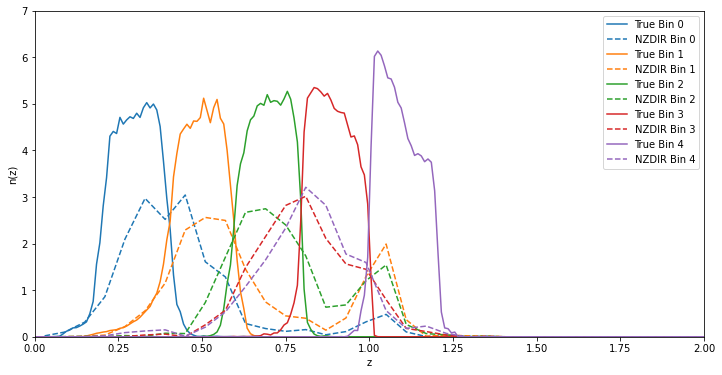

In [33]:
plt.figure(figsize=(12,6))
for i in range(5):
    line, = plt.plot(z_true, nz_true[i],'-', label=f'True Bin {i}')
    plt.plot(z_fid, nz_fid[i],'--', label=f'NZDIR Bin {i}', color=line.get_color())
plt.xlim(0, 2)
plt.legend()
plt.xlabel('z')
plt.ylabel(f'n(z)')
plt.ylim(0, 7)

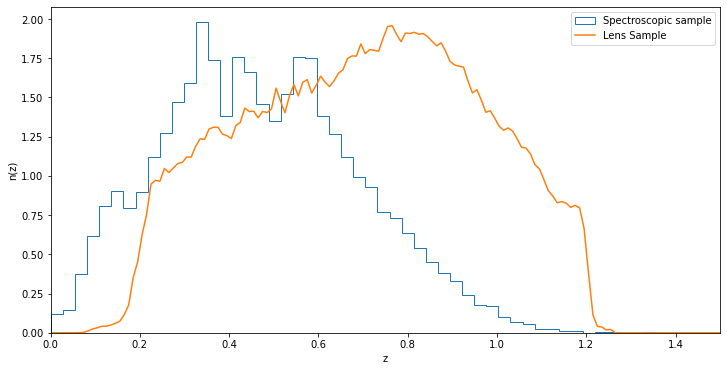

In [8]:
with txpipe.data_types.HDFFile(f"{data_dir}/spectroscopic_catalog.hdf5", "r")  as f:
    specz = f.file["photometry/redshift"][:]

plt.figure(figsize=(12,6))    
plt.hist(specz, bins=50, histtype="step", density=1, label="Spectroscopic sample");
plt.plot(z_2d, nz_2d*100, label="Lens Sample")
plt.xlabel("z")
plt.ylabel("n(z)")
plt.xlim(0, 1.5)
plt.legend()

# Comparison of realizations generated by NZ-DIR to truth

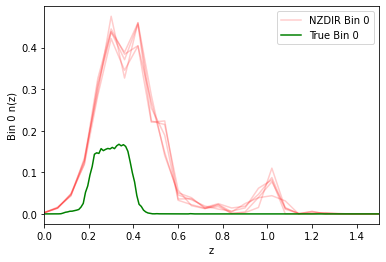

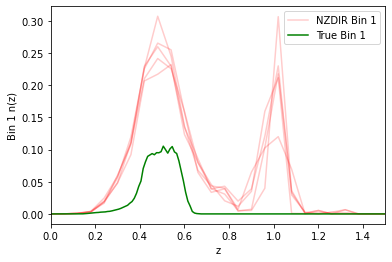

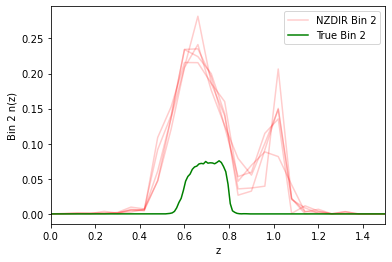

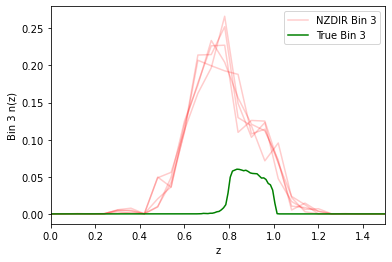

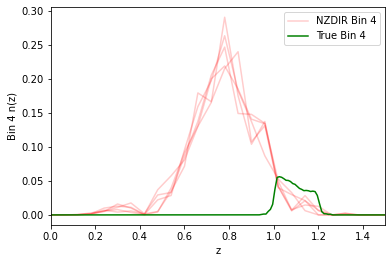

In [9]:
for j in range(nbin):
    plt.figure()
    for i in range(nreal):
        label = f"NZDIR Bin {j}" if i == 0 else None
        plt.plot(z_real, nz_real[j][i], 'r-', alpha=0.2, label=label)

    plt.plot(z_true, nz_true[j], 'g-', label=f'True Bin {j}')
    plt.xlim(0, 1.5)
    plt.legend()
    plt.xlabel('z')
    plt.ylabel(f'Bin {j} n(z)')

# Estimation of the mean shift between truth and NZ-DIR

In [10]:
def get_mean(z, nz):
    return (z * nz).sum() / nz.sum()

for i in range(nbin):
    true_mean = get_mean(z_true, nz_true[i])
    fid_mean = get_mean(z_fid, nz_fid[i])
    real_means = np.array([get_mean(z_real, nz_real[i][j]) for j in range(nreal)])
    delta_z = fid_mean - true_mean
    delta_z_err = (real_means - true_mean).std()
    print(f"Bin {i} delta z = {delta_z:.4f} ± {delta_z_err:.4f}")

Bin 0 delta z = 0.1406 ± 0.0053
Bin 1 delta z = 0.1699 ± 0.0119
Bin 2 delta z = 0.0633 ± 0.0090
Bin 3 delta z = -0.0826 ± 0.0058
Bin 4 delta z = -0.2765 ± 0.0070


In [11]:
with txpipe.data_types.NOfZFile(f"{data_dir}/lens_photoz_stack.hdf5", "r") as f:
    prov = dict(f.file['provenance'].attrs)


# Show configuration used

In [12]:
for key, val in prov.items():
    if key.startswith('config'):
        print(key[7:], '=', val)

aliases = {'tomography_catalog': 'lens_tomography_catalog', 'photometry_catalog': 'photometry_catalog', 'model': 'lens_somoclu_model', 'photoz_stack': 'lens_photoz_stack', 'photoz_realizations': 'lens_photoz_realizations'}
chunk_rows = 1000000
config = examples/cosmodc2/config-nz.yml
cprofile = 
leafsize = 20
mag_limits = {'u': 27.79, 'g': 29.04, 'r': 29.06, 'i': 28.62, 'z': 27.98, 'y': 27.05}
mag_prefix = photometry/mag_
memmon = 0
model = None
mpi = False
name = PZRailSummarizeLensSOM
nzbins = 50
pdb = False
photometry_catalog = /global/cfs/cdirs/lsst/groups/WL/users/zuntz/data/cosmoDC2-1.1.4_oneyear/photometry_catalog.hdf5
photoz_realizations = data/cosmodc2-nz/outputs/lens_photoz_realizations.hdf5
photoz_stack = data/cosmodc2-nz/outputs/lens_photoz_stack.hdf5
spec_groupname = 
spectroscopic_catalog = data/cosmodc2-nz/outputs/spectroscopic_catalog.hdf5
stage_name = PZRailSummarizeSpec
substage = somocluSOMSummarizer
tomography_catalog = data/cosmodc2-nz/outputs/lens_tomography_catal

# Show git version used

In [13]:
git_commit = prov['githead'].strip()
url = f"https://github.com/LSSTDESC/TXPipe/blob/{git_commit}/txpipe/rail/summarize.py"
print(url)


https://github.com/LSSTDESC/TXPipe/blob/11fe45367f1fd92dc589c9e2724759795d53fc36/txpipe/rail/summarize.py


# Show git diffs from that version 
## (Just for amusement - in this case there are no important code diffs)

In [14]:
print(prov['gitdiff'][:1000] + '\n...')

diff --git a/examples/cosmodc2/config-nz.yml b/examples/cosmodc2/config-nz.yml
index 069f1be..aaddc24 100644
--- a/examples/cosmodc2/config-nz.yml
+++ b/examples/cosmodc2/config-nz.yml
@@ -86,16 +86,9 @@ PZEstimatorLens:
     data_path: data/example/rail-bpz-inputs
     chunk_size: 1000000
 
-TXMeanLensSelector:
-    # Mag cuts
-    lens_zbin_edges: [0.0,0.2,0.4]
-    cperp_cut: 0.2
-    r_cpar_cut: 13.5
-    r_lo_cut: 16.0
-    r_hi_cut: 21.6
-    i_lo_cut: 17.5
-    i_hi_cut: 21.9
-    r_i_cut: 2.0
+TXRandomForestLensSelector:
+    lens_zbin_edges: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
+    mag_i_limit: 24.1
 
 
 Inform_NZDirLens:
diff --git a/examples/cosmodc2/pipeline-nz.yml b/examples/cosmodc2/pipeline-nz.yml
index 4e017a0..7bf5ab8 100644
--- a/examples/cosmodc2/pipeline-nz.yml
+++ b/examples/cosmodc2/pipeline-nz.yml
@@ -23,7 +23,7 @@ stages:
       nprocess: 128
       threads_per_process: 1
       nodes: 4
-    - name: TXMeanLensSelector     # select objects for lens bins from the PDFs